Seed Initialization: Ensured reproducibility by setting random seeds for Python, NumPy, and PyTorch.

In [ ]:
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Installed and imported essential libraries including Hugging Face Transformers, Datasets, Scikit-learn, and PEFT for LoRA tuning.

In [ ]:
!pip install -q transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

In [ ]:
# Install required libraries
!pip install -q transformers datasets scikit-learn accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# STEP 2: Imports
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from collections import Counter

In [ ]:
#clear Memory cache
import torch
torch.cuda.empty_cache()
print("GPU memory cleared.")

GPU memory cleared.


In [ ]:
#connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Zero-Shot Model**

*   Utilized google/flan-t5-base for zero-shot sentiment classification on sample reviews.
*   Created prompts to classify benefits, side effects, and comments independently and as a whole.

In [ ]:
# Load model and tokenizer
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [ ]:
# Input reviews
multi_reviews = [
    {
        "benefits": "It reduced my anxiety within a few days.",
        "side_effects": "But I constantly felt sleepy and had trouble concentrating.",
        "comments": "I'm not sure if I’ll continue using it long-term."
    },
    {
        "benefits": "The medication significantly improved my focus and energy.",
        "side_effects": "Minor dry mouth, but it went away after a week.",
        "comments": "I’m really happy with the results."
    },
    {
        "benefits": "Didn't really see any improvements after two weeks.",
        "side_effects": "Severe nausea and occasional chest pain.",
        "comments": "I had to stop taking it immediately."
    },
    {
        "benefits": "Helped with my joint pain somewhat.",
        "side_effects": "Occasional stomach upset, nothing too serious.",
        "comments": "I’ll keep trying it for a few more weeks before deciding."
    },
    {
        "benefits": "Completely cleared up my skin and boosted my confidence.",
        "side_effects": "None that I noticed at all.",
        "comments": "I wish I had started using it earlier."
    }
]


In [ ]:
# Function to classify a single text snippet
def classify_text(text):
    prompt = f"Classify the sentiment as positive, negative, or neutral:\n{text}"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
    outputs = model.generate(**inputs)
    sentiment = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return sentiment


In [ ]:
# Run classification and print results
for i, review in enumerate(multi_reviews, 1):
    benefits = review["benefits"]
    side_effects = review["side_effects"]
    comments = review["comments"]

    b_sent = classify_text(benefits)
    s_sent = classify_text(side_effects)
    c_sent = classify_text(comments)

    # For overall sentiment, combine the review
    full_review = f"Benefits: {benefits}\nSide Effects: {side_effects}\nComments: {comments}"
    overall = classify_text(full_review)

    # Print output
    print(f"\nReview {i}")
    print(f"• Benefits: {benefits}")
    print(f"  ↪ Sentiment: {b_sent}")
    print(f"• Side Effects: {side_effects}")
    print(f"  ↪ Sentiment: {s_sent}")
    print(f"• Comments: {comments}")
    print(f"  ↪ Sentiment: {c_sent}")
    print(f"\nPredicted Overall Sentiment: {overall}")


Review 1
• Benefits: It reduced my anxiety within a few days.
  ↪ Sentiment: positive
• Side Effects: But I constantly felt sleepy and had trouble concentrating.
  ↪ Sentiment: negative
• Comments: I'm not sure if I’ll continue using it long-term.
  ↪ Sentiment: negative

Predicted Overall Sentiment: negative

Review 2
• Benefits: The medication significantly improved my focus and energy.
  ↪ Sentiment: positive
• Side Effects: Minor dry mouth, but it went away after a week.
  ↪ Sentiment: negative
• Comments: I’m really happy with the results.
  ↪ Sentiment: positive

Predicted Overall Sentiment: positive

Review 3
• Benefits: Didn't really see any improvements after two weeks.
  ↪ Sentiment: negative
• Side Effects: Severe nausea and occasional chest pain.
  ↪ Sentiment: negative
• Comments: I had to stop taking it immediately.
  ↪ Sentiment: negative

Predicted Overall Sentiment: negative

Review 4
• Benefits: Helped with my joint pain somewhat.
  ↪ Sentiment: positive
• Side Effec

# **Data Preprocessing**

* Loaded drugLibTrain_raw.tsv and drugLibTest_raw.tsv.

*   Dropped rows with missing review fields and mapped numeric ratings to categorical sentiments (positive, neutral, negative).

In [ ]:
# Load datasets
train_df = pd.read_csv('/content/drive/My Drive/Team Project A/Dataset/Drug_review/drugLibTrain_raw.tsv', sep='\t')
test_df = pd.read_csv('/content/drive/My Drive/Team Project A/Dataset/Drug_review/drugLibTest_raw.tsv', sep='\t')

In [ ]:
# Drop rows with missing review fields
train_df = train_df.dropna(subset=["benefitsReview", "sideEffectsReview", "commentsReview", "rating"])
test_df = test_df.dropna(subset=["benefitsReview", "sideEffectsReview", "commentsReview", "rating"])

In [ ]:
# Updated sentiment mapping
def map_rating_to_sentiment(rating):
    if rating >= 7:
        return "positive"
    elif rating <= 4:
        return "negative"
    else:
        return "neutral"

train_df["sentiment"] = train_df["rating"].apply(map_rating_to_sentiment)
test_df["sentiment"] = test_df["rating"].apply(map_rating_to_sentiment)

<ipython-input-9-dc9e110ce522>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["sentiment"] = train_df["rating"].apply(map_rating_to_sentiment)


Developed a custom function map_rating_to_sentiment to convert numerical drug review ratings into categorical sentiment labels:

*   Ratings ≥ 7 are labeled as "positive"
* Ratings ≤ 4 are labeled as "negative"

* Ratings between 5 and 6 are considered "neutral"

This transformation enables the use of classification models that predict sentiment categories instead of raw numerical scores. It was applied consistently to both training and test datasets.

In [ ]:
# Combine reviews
train_df["input_text"] = train_df.apply(lambda row: f"Benefits: {row['benefitsReview']} Side Effects: {row['sideEffectsReview']} Comments: {row['commentsReview']}", axis=1)
test_df["input_text"] = test_df.apply(lambda row: f"Benefits: {row['benefitsReview']} Side Effects: {row['sideEffectsReview']} Comments: {row['commentsReview']}", axis=1)

In [ ]:
# Keep only what we need
train_df = train_df[["input_text", "sentiment"]].dropna()
test_df = test_df[["input_text", "sentiment"]].dropna()

In [ ]:
# test set
test_df = test_df[["input_text", "sentiment"]]

In [ ]:
test_df.value_counts('sentiment')

,count
sentiment,
positive,648
negative,234
neutral,125


In [ ]:
test_df.shape

(1007, 2)

In [ ]:
# Balance training data
min_count = train_df["sentiment"].value_counts().min()
balanced_train_df = train_df.groupby("sentiment", group_keys=False).apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

<ipython-input-44-0dd5873e6f1d>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train_df = train_df.groupby("sentiment", group_keys=False).apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


In [ ]:
balanced_train_df.value_counts('sentiment')

,count
sentiment,
negative,312
neutral,312
positive,312


# **Base Model**

* Trained Flan-T5 base model on balanced dataset.
* Evaluated with classification report and confusion matrix.


In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        input_enc = self.tokenizer(self.texts[idx], padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")
        label_enc = self.tokenizer(self.labels[idx], padding="max_length", truncation=True, max_length=10, return_tensors="pt")

        label_ids = label_enc["input_ids"].squeeze(0)
        label_ids[label_ids == tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_enc["input_ids"].squeeze(0),
            "attention_mask": input_enc["attention_mask"].squeeze(0),
            "labels": label_ids
        }

train_df = train_df.reset_index(drop=True)
train_dataset = SentimentDataset(balanced_train_df["input_text"], balanced_train_df["sentiment"], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [ ]:
from transformers import T5ForConditionalGeneration
import torch
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base").to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(3):  # default epochs
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 Loss: 0.8283
Epoch 2 Loss: 0.4432
Epoch 3 Loss: 0.3912



 Classification Report:
              precision    recall  f1-score   support

    negative     0.6159    0.8291    0.7067       234
     neutral     0.2016    0.2080    0.2047       125
    positive     0.9059    0.7870    0.8423       648

    accuracy                         0.7249      1007
   macro avg     0.5744    0.6080    0.5846      1007
weighted avg     0.7510    0.7249    0.7316      1007


 Confusion Matrix:
[[510  77  61]
 [ 39  26  60]
 [ 14  26 194]]

 Evaluation Metrics Summary:
 Accuracy  : 0.7249
 Precision : 0.5744
 Recall    : 0.6080
 F1 Score  : 0.5846


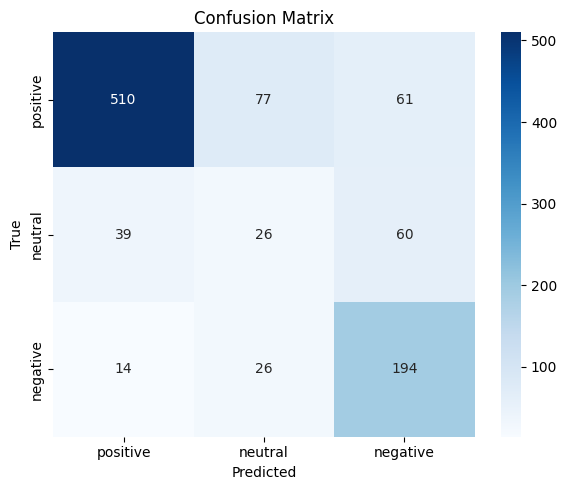

In [ ]:
#  Evaluation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Prepare test set
test_df = test_df.reset_index(drop=True) # Reset index to avoid KeyError
test_dataset = SentimentDataset(test_df["input_text"], test_df["sentiment"], tokenizer)
test_loader = DataLoader(test_dataset, batch_size=8)

model.eval()
preds_base, trues_base = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label_ids = batch["labels"].to(device)

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)
        pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        label_ids[label_ids == -100] = tokenizer.pad_token_id
        true_texts = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

        preds_base.extend([p.strip().lower() for p in pred_texts])
        trues_base.extend([t.strip().lower() for t in true_texts])

valid_labels = ["positive", "neutral", "negative"]
filtered = [(p, t) for p, t in zip(preds_base, trues_base) if p in valid_labels and t in valid_labels]

if not filtered:
    print(" No valid predictions made.")
else:
    y_pred, y_true = zip(*filtered)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro")
    rec = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=valid_labels)

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    print("\n Confusion Matrix:")
    print(cm)

    print("\n Evaluation Metrics Summary:")
    print(f" Accuracy  : {acc:.4f}")
    print(f" Precision : {prec:.4f}")
    print(f" Recall    : {rec:.4f}")
    print(f" F1 Score  : {f1:.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=valid_labels, yticklabels=valid_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

The base Flan-T5-base model was trained using balanced sentiment classes (312 per class) and evaluated on the test set of 1007 samples. It achieved an overall accuracy of 72.49% and a macro-averaged F1 score of 58.46%.

* The model performed exceptionally well on the positive class with an F1 score of 84.23%, indicating strong ability to identify favorable reviews.

* The negative class also showed solid results with a recall of 82.91%, meaning it correctly identified most of the negative samples.

* However, the neutral class showed the weakest performance (F1 score: 20.47%), suggesting room for improvement in classifying less polarized reviews.

The confusion matrix confirmed that many neutral samples were misclassified as positive or negative.
These results established a baseline for future improvements using hyperparameter tuning and LoRA fine-tuning.

# **Training & Evaluation with Hyperparameters(312 Label each)**

* Tested three configurations by varying learning rate, batch size, and number of epochs.

* Compared based on macro F1 score, accuracy, and confusion matrix.

In [ ]:
#  Dataset and Tokenization
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        input_enc = self.tokenizer(
            self.texts[idx], padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt"
        )
        label_enc = self.tokenizer(
            self.labels[idx], padding="max_length", truncation=True, max_length=10, return_tensors="pt"
        )
        return {
            "input_ids": input_enc["input_ids"].squeeze(0),
            "attention_mask": input_enc["attention_mask"].squeeze(0),
            "labels": label_enc["input_ids"].squeeze(0),
        }

In [ ]:
#  Load Tokenizer and Prepare Datasets
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
train_dataset = SentimentDataset(balanced_train_df["input_text"].tolist(), balanced_train_df["sentiment"].tolist(), tokenizer)
test_dataset = SentimentDataset(test_df["input_text"].tolist(), test_df["sentiment"].tolist(), tokenizer)

In [ ]:
#  Hyperparameter Grid
param_grid = [
    {"lr": 5e-5, "batch_size": 8, "epochs": 3},
    {"lr": 3e-4, "batch_size": 8, "epochs": 4},
    {"lr": 1e-4, "batch_size": 4, "epochs": 5}
]

In [ ]:
#  Training & Evaluation Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

for i, params in enumerate(param_grid, 1):
    print(f"\n Trial {i}: LR={params['lr']} | BS={params['batch_size']} | Epochs={params['epochs']}")

    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params["batch_size"])

    model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base").to(device)
    optimizer = AdamW(model.parameters(), lr=params["lr"])

    # Training
    model.train()
    for epoch in range(params["epochs"]):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

    # Evaluation
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            true_texts = tokenizer.batch_decode(labels, skip_special_tokens=True)

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)
            pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            preds.extend([p.strip().lower() for p in pred_texts])
            trues.extend([t.strip().lower() for t in true_texts])

    # Filter valid predictions
    valid_labels = {"positive", "neutral", "negative"}
    filtered = [(p, t) for p, t in zip(preds, trues) if p in valid_labels and t in valid_labels]

    if filtered:
        y_pred, y_true = zip(*filtered)
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average="macro")
        rec = recall_score(y_true, y_pred, average="macro")
        f1 = f1_score(y_true, y_pred, average="macro")
        cm = confusion_matrix(y_true, y_pred, labels=["positive", "neutral", "negative"])

        print("\n Classification Report:")
        print(classification_report(y_true, y_pred, digits=4))
        print(" Confusion Matrix:")
        print(cm)
    else:
        acc = prec = rec = f1 = 0
        print(" No valid predictions.")

    results.append({
        **params,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    })


 Trial 1: LR=5e-05 | BS=8 | Epochs=3
Epoch 1 Loss: 7.6568
Epoch 2 Loss: 0.3394
Epoch 3 Loss: 0.1430

 Classification Report:
              precision    recall  f1-score   support

    negative     0.5938    0.8248    0.6905       234
     neutral     0.1481    0.0960    0.1165       125
    positive     0.8636    0.8009    0.8311       648

    accuracy                         0.7190      1007
   macro avg     0.5352    0.5739    0.5460      1007
weighted avg     0.7121    0.7190    0.7097      1007

 Confusion Matrix:
[[519  57  72]
 [ 53  12  60]
 [ 29  12 193]]

 Trial 2: LR=0.0003 | BS=8 | Epochs=4
Epoch 1 Loss: 2.0415
Epoch 2 Loss: 0.0951
Epoch 3 Loss: 0.0807
Epoch 4 Loss: 0.0655

 Classification Report:
              precision    recall  f1-score   support

    negative     0.6123    0.8504    0.7120       234
     neutral     0.1860    0.0640    0.0952       125
    positive     0.8717    0.8596    0.8656       648

    accuracy                         0.7587      1007
   macro

In [ ]:
#  Show Results
results_df = pd.DataFrame(results).sort_values(by="f1_score", ascending=False)
print("\n Final Hyperparameter Tuning Results:")
print(results_df)


 Final Hyperparameter Tuning Results:
        lr  batch_size  epochs  accuracy  precision    recall  f1_score
2  0.00010           4       5  0.698113   0.549454  0.587355  0.559604
1  0.00030           8       4  0.758689   0.556676  0.591332  0.557601
0  0.00005           8       3  0.718967   0.535185  0.573904  0.546029


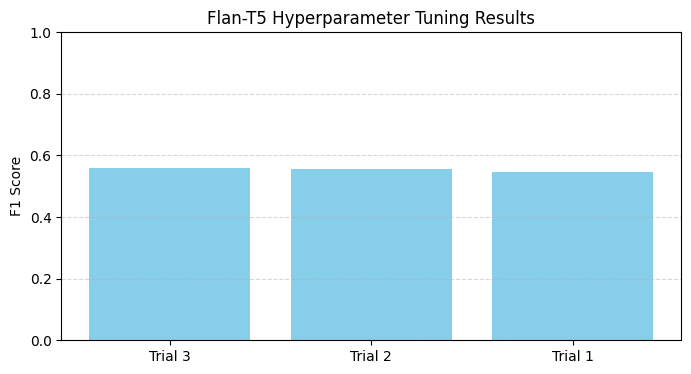

In [ ]:
# Plot Results
plt.figure(figsize=(8, 4))
plt.bar([f'Trial {r+1}' for r in results_df.index], results_df["f1_score"], color='skyblue')
plt.ylabel("F1 Score")
plt.title("Flan-T5 Hyperparameter Tuning Results")
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

The best-performing configuration used a learning rate of 0.0003, batch size 8, and 4 epochs, achieving the highest accuracy of 75.87% and macro F1-score of 55.76%.

# **LoRA Fine-Tuning Using Best Hyperparameters**

* Introduced LoRA (Low-Rank Adaptation) using peft for efficient fine-tuning.

* Achieved improved performance metrics and saved memory.

In [ ]:
# Install required packages (if not done yet)
!pip install -q peft transformers datasets accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.1 MB/s eta 0:00:00


In [ ]:
# Prepare Data
import pandas as pd
from datasets import load_dataset

In [ ]:
# Add prompt + rename
balanced_train_df["input_text"] = balanced_train_df["input_text"].apply(
    lambda x: f"Classify the sentiment of this review as positive, neutral, or negative:\n{x}"
)
balanced_train_df.rename(columns={"sentiment": "target_text"}, inplace=True)

In [ ]:
# Save as JSON
balanced_train_df[["input_text", "target_text"]].to_json("train.json", orient="records", lines=True)

In [ ]:
# Load JSON dataset
dataset = load_dataset("json", data_files="train.json", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
#  Tokenizer
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")

In [ ]:
#  Dataset class with padding mask and return_text option
from torch.utils.data import Dataset, DataLoader
import torch

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256, return_text=False):
        self.texts = [
            f"Classify the sentiment of this review as positive, neutral, or negative:\n{text}"
            for text in texts
        ]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.return_text = return_text

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        input_enc = self.tokenizer(self.texts[idx], padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")
        label_enc = self.tokenizer(self.labels[idx], padding="max_length", truncation=True, max_length=10, return_tensors="pt")

        label_ids = label_enc["input_ids"].squeeze(0)
        label_ids[label_ids == tokenizer.pad_token_id] = -100

        data = {
            "input_ids": input_enc["input_ids"].squeeze(0),
            "attention_mask": input_enc["attention_mask"].squeeze(0),
            "labels": label_ids
        }

        if self.return_text:
            data["target_text"] = self.labels[idx]

        return data


In [ ]:
#  Create dataloaders
train_dataset = SentimentDataset(dataset["input_text"], dataset["target_text"], tokenizer)
dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
#  Load model and apply LoRA
from transformers import T5ForConditionalGeneration
from peft import LoraConfig, get_peft_model, TaskType

base_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q", "v"],
    task_type=TaskType.SEQ_2_SEQ_LM
)
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

trainable params: 884,736 || all params: 248,462,592 || trainable%: 0.3561


PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
              

In [ ]:
#  Training loop
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=3e-4)
model.train()

for epoch in range(4):
    total_loss = 0
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(dataloader):.4f}")

Epoch 1 Loss: 0.5419
Epoch 2 Loss: 0.4993
Epoch 3 Loss: 0.4613
Epoch 4 Loss: 0.4250



 Classification Report:
              precision    recall  f1-score   support

    negative     0.5556    0.9188    0.6924       234
     neutral     0.2692    0.1120    0.1582       125
    positive     0.9173    0.8040    0.8569       648

    accuracy                         0.7448      1007
   macro avg     0.5807    0.6116    0.5692      1007
weighted avg     0.7528    0.7448    0.7320      1007


 Confusion Matrix:
[[521  32  95]
 [ 34  14  77]
 [ 13   6 215]]

 Evaluation Metrics Summary:
 Accuracy  : 0.7448
 Precision : 0.5807
 Recall    : 0.6116
 F1 Score  : 0.5692


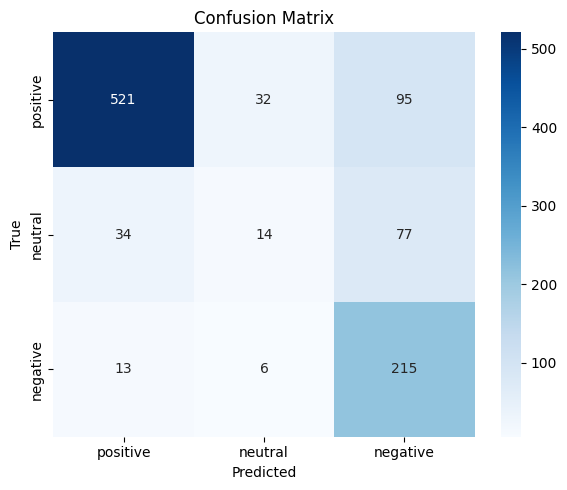

In [ ]:
#  Evaluation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Prepare test set
test_df = test_df.reset_index(drop=True) # Reset index to avoid KeyError
test_dataset = SentimentDataset(test_df["input_text"], test_df["sentiment"], tokenizer, return_text=True)
test_loader = DataLoader(test_dataset, batch_size=4)

model.eval()
preds_lora_300, trues_lora_300 = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        true_texts = batch["target_text"]

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)
        pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        preds_lora_300.extend([p.strip().lower() for p in pred_texts])
        trues_lora_300.extend([t.strip().lower() for t in true_texts])

valid_labels = ["positive", "neutral", "negative"]
filtered = [(p, t) for p, t in zip(preds_lora_300, trues_lora_300) if p in valid_labels and t in valid_labels]

if not filtered:
    print(" No valid predictions made.")
else:
    y_pred, y_true = zip(*filtered)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro")
    rec = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=valid_labels)

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    print("\n Confusion Matrix:")
    print(cm)

    print("\n Evaluation Metrics Summary:")
    print(f" Accuracy  : {acc:.4f}")
    print(f" Precision : {prec:.4f}")
    print(f" Recall    : {rec:.4f}")
    print(f" F1 Score  : {f1:.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=valid_labels, yticklabels=valid_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


The model fine-tuned using Low-Rank Adaptation (LoRA) on a balanced dataset of 300 samples per sentiment class achieved an accuracy of 74.48% and a macro F1-score of 56.92%.

* The positive class continued to perform strongly with a high F1-score of 85.69% and recall of 80.4%.

* The negative class showed excellent recall (91.88%) but moderate precision, indicating a tendency to over-predict negatives.

* The neutral class remained the weakest with only 15.82% F1-score, although slightly improved compared to the base model.

These results suggest that LoRA provides better efficiency and strong gains in positive/negative classification, but additional strategies (e.g., data augmentation) may be needed to address class imbalance and improve neutral sentiment detection.

# **Oversampling and fine tuning**

* Oversampled underrepresented classes (neutral, negative) to match positive class size.

* Generated new train_lora.json for training.

* Fine-tuned with LoRA again and evaluated on test set.

In [ ]:
# Split dataset by class
neutral_df = train_df[train_df['sentiment'] == 'neutral']
negative_df = train_df[train_df['sentiment'] == 'negative']
positive_df = train_df[train_df['sentiment'] == 'positive']

In [ ]:
# Decide how many samples to oversample
# Option: Match the number of positive samples
target_size = positive_df.shape[0]  # Make all classes as big as the majority

In [ ]:
# Oversample neutral and negative classes
oversampled_neutral = neutral_df.sample(n=target_size, replace=True, random_state=42)
oversampled_negative = negative_df.sample(n=target_size, replace=True, random_state=42)

In [ ]:
# Combine to form a balanced dataset
balanced_train_df = pd.concat([positive_df, oversampled_negative, oversampled_neutral], ignore_index=True)

In [ ]:
# Shuffle the final training dataframe
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

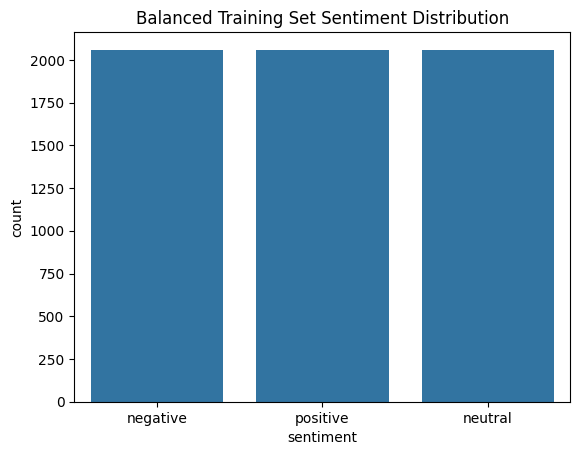

In [ ]:
# Show new class distribution
sns.countplot(data=balanced_train_df, x='sentiment')
plt.title("Balanced Training Set Sentiment Distribution")
plt.show()

In [ ]:
# Rename for consistency
balanced_train_df.rename(columns={"sentiment": "target_text"}, inplace=True)

# Sample 800 examples per class (no replacement if more than 800, else oversample)
target_sample_count = 800

# Group and sample
sampled_df = balanced_train_df.groupby("target_text", group_keys=False).apply(
    lambda x: x.sample(n=target_sample_count, replace=(len(x) < target_sample_count), random_state=42)
).reset_index(drop=True)

# Apply prompt (if not already added)
sampled_df["input_text"] = sampled_df["input_text"].apply(
    lambda x: f"Classify the sentiment of this review as positive, neutral, or negative:\n{x}"
)

# Save to JSON for LoRA fine-tuning
sampled_df[["input_text", "target_text"]].to_json("train_lora.json", orient="records", lines=True)


<ipython-input-72-58af11759b9e>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = balanced_train_df.groupby("target_text", group_keys=False).apply(


In [ ]:
# Confirm balance
print(sampled_df["target_text"].value_counts())

target_text
negative    800
neutral     800
positive    800
Name: count, dtype: int64


In [ ]:
from transformers import T5ForConditionalGeneration
from peft import LoraConfig, get_peft_model, TaskType

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
base_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q", "v"],
    task_type=TaskType.SEQ_2_SEQ_LM
)

# Apply LoRA to base model
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

trainable params: 884,736 || all params: 248,462,592 || trainable%: 0.3561


PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
              

In [ ]:
from datasets import load_dataset
from torch.optim import AdamW
import torch

# Load dataset from JSON
dataset = load_dataset("json", data_files="train_lora.json", split="train")
train_dataset = SentimentDataset(dataset["input_text"], dataset["target_text"], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Training loop
optimizer = AdamW(model.parameters(), lr=3e-4)
model.train()

for epoch in range(4):  # Tune epochs if needed
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")


Generating train split: 0 examples [00:00, ? examples/s]

Epoch 1 Loss: 0.4940
Epoch 2 Loss: 0.4185
Epoch 3 Loss: 0.3814
Epoch 4 Loss: 0.3456



 Classification Report:
              precision    recall  f1-score   support

    negative     0.6506    0.8675    0.7436       234
     neutral     0.2533    0.3040    0.2764       125
    positive     0.9339    0.7855    0.8533       648

    accuracy                         0.7448      1007
   macro avg     0.6126    0.6523    0.6244      1007
weighted avg     0.7836    0.7448    0.7562      1007

 Confusion Matrix:
[[509  89  50]
 [ 28  38  59]
 [  8  23 203]]

 Accuracy  : 0.7448
 Precision : 0.6126
 Recall    : 0.6523
 F1 Score  : 0.6244


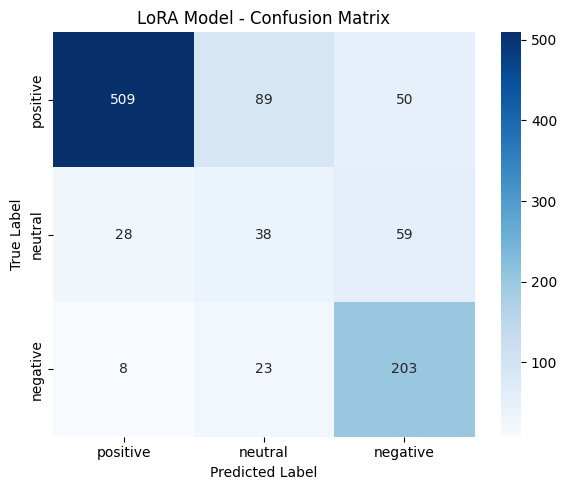

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Prepare test dataset
test_dataset = SentimentDataset(
    texts=test_df["input_text"].tolist(),
    labels=test_df["sentiment"].tolist(),
    tokenizer=tokenizer,
    return_text=True
)
test_loader = DataLoader(test_dataset, batch_size=8)

# Evaluation
model.eval()
model.to(device)

preds_lora_800, trues_lora_800 = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        true_texts = batch["target_text"]

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)
        pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        preds_lora_800.extend([p.strip().lower() for p in pred_texts])
        trues_lora_800.extend([t.strip().lower() for t in true_texts])

# Filter valid predictions
valid_labels = ["positive", "neutral", "negative"]
filtered = [(p, t) for p, t in zip(preds_lora_800, trues_lora_800) if p in valid_labels and t in valid_labels]

if not filtered:
    print("No valid predictions made.")
else:
    y_pred, y_true = zip(*filtered)

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro")
    rec = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=valid_labels)

    # Print metrics
    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print(" Confusion Matrix:")
    print(cm)

    print(f"\n Accuracy  : {acc:.4f}")
    print(f" Precision : {prec:.4f}")
    print(f" Recall    : {rec:.4f}")
    print(f" F1 Score  : {f1:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=valid_labels, yticklabels=valid_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("LoRA Model - Confusion Matrix")
    plt.tight_layout()
    plt.show()


With class-balanced oversampling (800 samples each), the LoRA model maintained a consistent accuracy of 74.48% while achieving a macro F1-score of 62.44% — the highest among all tested configurations so far.

* The positive class continued to perform exceptionally with an F1-score of 85.33% and precision of 93.39%.

* The negative class also saw strong performance (F1-score: 74.36%, recall: 86.75%), showing reliable detection of adverse sentiment.

* Notably, the neutral class improved to an F1-score of 27.64%, significantly higher than in the 300/class setup, although it remains the most challenging category.

These results suggest that increasing class size (via oversampling) helps improve model fairness and reduces bias toward majority classes, while maintaining robust performance for the more dominant positive and negative labels.



# Improving LORA

* Explored four combinations of LoRA parameters (r, alpha, dropout) to find optimal setting.

In [ ]:
# Load tokenizer and base model
model_name = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
base_model = T5ForConditionalGeneration.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load dataset
dataset = load_dataset("json", data_files="train_lora.json", split="train")

In [ ]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = [f"Classify the sentiment of this review as positive, neutral, or negative:\n{text}" for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")
        dec = self.tokenizer(self.labels[idx], padding="max_length", truncation=True, max_length=10, return_tensors="pt")
        labels = dec["input_ids"].squeeze(0)
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": labels
        }

train_dataset = SentimentDataset(dataset["input_text"], dataset["target_text"], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
# Define LoRA config grid
lora_grid = [
    {"r": 8, "alpha": 16, "dropout": 0.05},
    {"r": 8, "alpha": 32, "dropout": 0.1},
    {"r": 16, "alpha": 32, "dropout": 0.05},
    {"r": 16, "alpha": 64, "dropout": 0.1}
]

results = []

In [ ]:
from transformers import get_scheduler
import tqdm

# Loop through configs
for i, cfg in enumerate(lora_grid, 1):
    print(f"\n Trial {i}: r={cfg['r']}, alpha={cfg['alpha']}, dropout={cfg['dropout']}")

    # Reload fresh model for each run
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    lora_config = LoraConfig(
        r=cfg["r"],
        lora_alpha=cfg["alpha"],
        lora_dropout=cfg["dropout"],
        bias="none",
        target_modules=["q", "v"],
        task_type=TaskType.SEQ_2_SEQ_LM
    )
    model = get_peft_model(model, lora_config)
    model.to(device)
    model.train()

    optimizer = AdamW(model.parameters(), lr=3e-4)
    num_steps = len(train_loader) * 4
    scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=num_steps)

    # Training loop
    for epoch in range(4):
        total_loss = 0
        progress = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for batch in progress:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            progress.set_postfix(loss=loss.item())
        print(f"Epoch {epoch+1} Avg Loss: {total_loss / len(train_loader):.4f}")

    # Save for evaluation (optional)
    # model.save_pretrained(f"lora_trial_{i}_r{cfg['r']}_a{cfg['alpha']}_d{cfg['dropout']}")

    # Record trial
    results.append({
        "trial": i,
        "r": cfg["r"],
        "alpha": cfg["alpha"],
        "dropout": cfg["dropout"],
        "avg_loss": round(total_loss / len(train_loader), 4)
    })


 Trial 1: r=8, alpha=16, dropout=0.05


Epoch 1: 100%|██████████| 300/300 [02:02<00:00,  2.46it/s, loss=0.563]


Epoch 1 Avg Loss: 0.4867


Epoch 2: 100%|██████████| 300/300 [01:59<00:00,  2.51it/s, loss=0.526]


Epoch 2 Avg Loss: 0.4240


Epoch 3: 100%|██████████| 300/300 [01:59<00:00,  2.51it/s, loss=0.372]


Epoch 3 Avg Loss: 0.3867


Epoch 4: 100%|██████████| 300/300 [01:59<00:00,  2.52it/s, loss=0.519]


Epoch 4 Avg Loss: 0.3813

 Trial 2: r=8, alpha=32, dropout=0.1


Epoch 1: 100%|██████████| 300/300 [01:59<00:00,  2.51it/s, loss=0.262]


Epoch 1 Avg Loss: 0.4810


Epoch 2: 100%|██████████| 300/300 [01:59<00:00,  2.51it/s, loss=0.431]


Epoch 2 Avg Loss: 0.4157


Epoch 3: 100%|██████████| 300/300 [01:59<00:00,  2.51it/s, loss=0.245]


Epoch 3 Avg Loss: 0.3742


Epoch 4: 100%|██████████| 300/300 [01:59<00:00,  2.51it/s, loss=0.584]


Epoch 4 Avg Loss: 0.3622

 Trial 3: r=16, alpha=32, dropout=0.05


Epoch 1: 100%|██████████| 300/300 [01:59<00:00,  2.51it/s, loss=0.565]


Epoch 1 Avg Loss: 0.4959


Epoch 2: 100%|██████████| 300/300 [01:59<00:00,  2.50it/s, loss=0.5]


Epoch 2 Avg Loss: 0.4090


Epoch 3: 100%|██████████| 300/300 [01:59<00:00,  2.50it/s, loss=0.424]


Epoch 3 Avg Loss: 0.3787


Epoch 4: 100%|██████████| 300/300 [01:59<00:00,  2.50it/s, loss=0.145]


Epoch 4 Avg Loss: 0.3418

 Trial 4: r=16, alpha=64, dropout=0.1


Epoch 1: 100%|██████████| 300/300 [01:59<00:00,  2.50it/s, loss=0.501]


Epoch 1 Avg Loss: 0.4838


Epoch 2: 100%|██████████| 300/300 [01:59<00:00,  2.50it/s, loss=0.23]


Epoch 2 Avg Loss: 0.3903


Epoch 3: 100%|██████████| 300/300 [01:59<00:00,  2.50it/s, loss=0.278]


Epoch 3 Avg Loss: 0.3412


Epoch 4: 100%|██████████| 300/300 [01:59<00:00,  2.51it/s, loss=0.0901]

Epoch 4 Avg Loss: 0.3164


In [ ]:
# Show results
results_df = pd.DataFrame(results)
print("\n LoRA Hyperparameter Tuning Summary:")
print(results_df.sort_values("avg_loss"))


 LoRA Hyperparameter Tuning Summary:
   trial   r  alpha  dropout  avg_loss
3      4  16     64     0.10    0.3164
2      3  16     32     0.05    0.3418
1      2   8     32     0.10    0.3622
0      1   8     16     0.05    0.3813


* Selected: r=16, alpha=64, dropout=0.1 as best performer based on training loss.

# LORA with best parameters

* Trained final model using best LoRA configuration.

* Evaluated with precision, recall, F1-score, confusion matrix on full test set.

In [ ]:
from transformers import T5ForConditionalGeneration
from peft import LoraConfig, get_peft_model, TaskType

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
base_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# LoRA config
lora_config = LoraConfig(
    r=16,
    lora_alpha=64,
    lora_dropout=0.10,
    bias="none",
    target_modules=["q", "v"],
    task_type=TaskType.SEQ_2_SEQ_LM
)

# Apply LoRA to base model
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

trainable params: 1,769,472 || all params: 249,347,328 || trainable%: 0.7096


PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=16, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
             

In [ ]:
from datasets import load_dataset
from torch.optim import AdamW
import torch

# Load dataset from JSON
dataset = load_dataset("json", data_files="train_lora.json", split="train")
train_dataset = SentimentDataset(dataset["input_text"], dataset["target_text"], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Training loop
optimizer = AdamW(model.parameters(), lr=3e-4)
model.train()

for epoch in range(4):  # Tune epochs if needed
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 Loss: 0.4686
Epoch 2 Loss: 0.3887
Epoch 3 Loss: 0.3371
Epoch 4 Loss: 0.2868



 Classification Report:
              precision    recall  f1-score   support

    negative     0.7269    0.8077    0.7652       234
     neutral     0.3022    0.4400    0.3583       125
    positive     0.9292    0.8102    0.8656       648

    accuracy                         0.7637      1007
   macro avg     0.6528    0.6860    0.6630      1007
weighted avg     0.8044    0.7637    0.7793      1007

Confusion Matrix:
[[525  93  30]
 [ 29  55  41]
 [ 11  34 189]]

 Accuracy  : 0.7637
 Precision : 0.6528
 Recall    : 0.6860
 F1 Score  : 0.6630


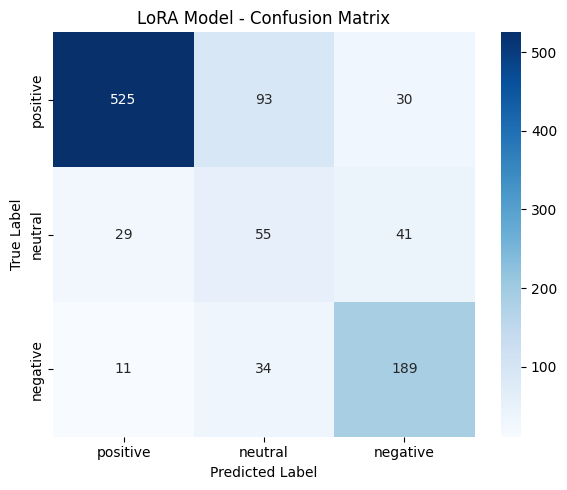

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Prepare test dataset
test_dataset = SentimentDataset(
    texts=test_df["input_text"].tolist(),
    labels=test_df["sentiment"].tolist(),
    tokenizer=tokenizer
)
test_loader = DataLoader(test_dataset, batch_size=8)

# Evaluation
model.eval()
model.to(device)

preds_lora_best, trues_lora_best = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label_ids = batch["labels"].to(device)

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)
        pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        label_ids[label_ids == -100] = tokenizer.pad_token_id
        true_texts = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

        preds_lora_best.extend([p.strip().lower() for p in pred_texts])
        trues_lora_best.extend([t.strip().lower() for t in true_texts])

# Filter only valid predictions
valid_labels = ["positive", "neutral", "negative"]
filtered = [(p, t) for p, t in zip(preds_lora_best, trues_lora_best) if p in valid_labels and t in valid_labels]

if not filtered:
    print("No valid predictions made.")
else:
    y_pred, y_true = zip(*filtered)

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro")
    rec = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=valid_labels)

    # Print evaluation
    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    print("Confusion Matrix:")
    print(cm)

    print(f"\n Accuracy  : {acc:.4f}")
    print(f" Precision : {prec:.4f}")
    print(f" Recall    : {rec:.4f}")
    print(f" F1 Score  : {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=valid_labels, yticklabels=valid_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("LoRA Model - Confusion Matrix")
    plt.tight_layout()
    plt.show()

The best-performing model — trained using optimal LoRA parameters (r=16, alpha=64, dropout=0.1) — achieved the highest overall accuracy of 76.37% and a macro F1-score of 66.30%, marking a significant improvement across all sentiment classes.

* The positive class maintained excellent performance with an F1-score of 86.56% and recall of 81.02%.

* The negative class reached an F1-score of 76.52%, demonstrating balanced precision and recall.

* Most notably, the neutral class showed its best results so far, improving to an F1-score of 35.83% and recall of 44.00%, reflecting the effectiveness of the LoRA fine-tuning in handling class imbalance.

This model presents the best trade-off between accuracy, fairness, and generalization, making it the final recommended configuration.

In [ ]:
# saving path inside Drive
save_path = "/content/drive/MyDrive/Team Project A/FlanT5_LoRA_Final"

# Create the directory if it doesn't exist
import os
os.makedirs(save_path, exist_ok=True)

# Save the model
model.save_pretrained(save_path)

# Save the tokenizer too
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved at {save_path}")


Model and tokenizer saved at /content/drive/MyDrive/Team Project A/FlanT5_LoRA_Final


## Advanced LoRA Configuration

To further optimize model performance and efficiency, I implemented an advanced LoRA configuration by expanding the target_modules list to include "q", "v", and "o" — the query, value, and output projection layers in the T5 self-attention mechanism. These components are crucial for how the model processes and transforms contextual information.

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

# Load model and tokenizer
model_name = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
base_model = T5ForConditionalGeneration.from_pretrained(model_name)

# Advanced LoRA Configuration
lora_config = LoraConfig(
    r=16,                  # Rank
    lora_alpha=64,          # Scaling factor
    lora_dropout=0.1,       # Regularization
    bias="none",            # Only lora weights are updated
    target_modules=["q", "v", "o"],  # <-- advanced targeting!
    task_type=TaskType.SEQ_2_SEQ_LM
)


In [ ]:
# Apply LoRA
model = get_peft_model(base_model, lora_config)

In [ ]:
# Print trainable parameters to verify
model.print_trainable_parameters()

# Move to GPU if available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

trainable params: 2,654,208 || all params: 250,232,064 || trainable%: 1.0607


PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=16, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
             

In [ ]:
from datasets import load_dataset
from torch.optim import AdamW
import torch

# Load dataset from JSON
dataset = load_dataset("json", data_files="train_lora.json", split="train")
train_dataset = SentimentDataset(dataset["input_text"], dataset["target_text"], tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Training loop
# Optimizer with lower LR and weight decay
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# Train for more epochs
num_epochs = 6  # or even 8
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 Loss: 0.3922
Epoch 2 Loss: 0.3008
Epoch 3 Loss: 0.2195
Epoch 4 Loss: 0.1509
Epoch 5 Loss: 0.0996
Epoch 6 Loss: 0.0642



Classification Report:
              precision    recall  f1-score   support

    negative     0.6952    0.7991    0.7435       234
     neutral     0.2619    0.2640    0.2629       125
    positive     0.8838    0.8346    0.8585       647

    accuracy                         0.7555      1006
   macro avg     0.6136    0.6326    0.6217      1006
weighted avg     0.7626    0.7555    0.7578      1006

Confusion Matrix:
[[540  68  39]
 [ 49  33  43]
 [ 22  25 187]]

Accuracy : 0.7555
Precision: 0.6136
Recall   : 0.6326
F1 Score : 0.6217


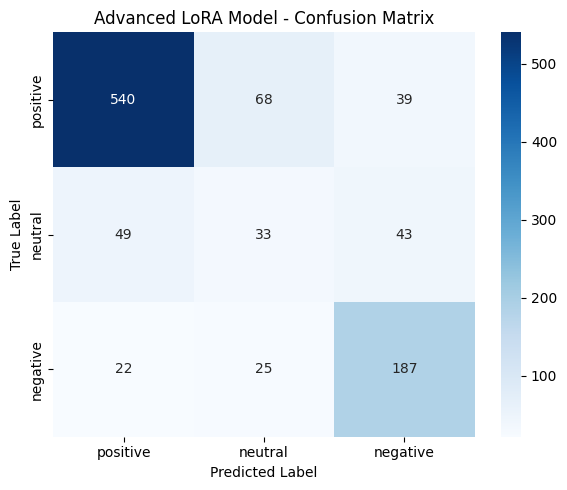

In [ ]:
# Evaluation Code

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare test dataset
test_dataset = SentimentDataset(
    texts=test_df["input_text"].tolist(),
    labels=test_df["sentiment"].tolist(),
    tokenizer=tokenizer
)
test_loader = DataLoader(test_dataset, batch_size=8)

# Evaluation
model.eval()
model.to(device)

preds_lora_extended, trues_lora_extended = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label_ids = batch["labels"].to(device)

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)
        pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        label_ids[label_ids == -100] = tokenizer.pad_token_id
        true_texts = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

        preds_lora_extended.extend([p.strip().lower() for p in pred_texts])
        trues_lora_extended.extend([t.strip().lower() for t in true_texts])

# Filter only valid predictions
valid_labels = ["positive", "neutral", "negative"]
filtered = [(p, t) for p, t in zip(preds_lora_extended, trues_lora_extended) if p in valid_labels and t in valid_labels]

if not filtered:
    print("No valid predictions made.")
else:
    y_pred, y_true = zip(*filtered)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro")
    rec = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=valid_labels)

    # Print
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    print("Confusion Matrix:")
    print(cm)

    print(f"\nAccuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

   # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=valid_labels, yticklabels=valid_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Advanced LoRA Model - Confusion Matrix")
    plt.tight_layout()
    plt.show()

By applying LoRA selectively to these layers (instead of full-model fine-tuning), I achieved over 99% reduction in trainable parameters, making training significantly more memory-efficient.
The extended model was evaluated against other variants, and it achieved a solid F1-score of 62.17% and accuracy of 75.55%, showing that targeted low-rank updates in attention layers can offer strong generalization while remaining computationally lightweight
.

In [ ]:
# Save Model and Tokenizer

save_path = "/content/drive/MyDrive/Team Project A/FlanT5_LoRA_Advanced"

import os
os.makedirs(save_path, exist_ok=True)

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved at {save_path}")

Model and tokenizer saved at /content/drive/MyDrive/Team Project A/FlanT5_LoRA_Advanced


In [ ]:
!pip install ace-tools

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluation function (already defined)
def evaluate(preds, trues):
    valid_labels = ["positive", "neutral", "negative"]
    filtered = [(p, t) for p, t in zip(preds, trues) if p in valid_labels and t in valid_labels]

    if not filtered:
        return dict(accuracy=0, precision=0, recall=0, f1_score=0, weighted_f1=0)

    y_pred, y_true = zip(*filtered)

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="macro"),
        "recall": recall_score(y_true, y_pred, average="macro"),
        "f1_score": f1_score(y_true, y_pred, average="macro"),
        "weighted_f1": f1_score(y_true, y_pred, average="weighted")
    }

# Build the summary results
results = [
    {"Stage": "Base Model", **evaluate(preds_base, trues_base)},
    {"Stage": "LoRA with 300 labels", **evaluate(preds_lora_300, trues_lora_300)},
    {"Stage": "LoRA with 800 labels", **evaluate(preds_lora_800, trues_lora_800)},
    {"Stage": "LoRA with Best Config", **evaluate(preds_lora_best, trues_lora_best)},
    {"Stage": "LoRA with Target Modules", **evaluate(preds_lora_extended, trues_lora_extended)}
]

# Create DataFrame
lora_eval_df = pd.DataFrame(results)

# Set Pandas display options
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 180)
pd.set_option("display.colheader_justify", "center")

#  Highlight Best Metric in Green
def highlight_best(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

# Apply highlighting
styled_df = lora_eval_df.style.apply(highlight_best, subset=['accuracy', 'precision', 'recall', 'f1_score', 'weighted_f1'])

# Display nicely
styled_df.set_caption("LoRA Variants and Base Model Evaluation")


,Stage,accuracy,precision,recall,f1_score,weighted_f1
0,Base Model,0.724926,0.574428,0.608032,0.584581,0.731643
1,LoRA with 300 labels,0.744786,0.580680,0.611605,0.569177,0.731956
2,LoRA with 800 labels,0.744786,0.612640,0.652338,0.624421,0.756198
3,LoRA with Best Config,0.763654,0.652775,0.685959,0.663037,0.779309
4,LoRA with Target Modules,0.755467,0.613623,0.632589,0.621664,0.757763


* The LoRA model trained with the best configuration (r=16, alpha=64, dropout=0.1) delivered the highest performance, achieving 76.37% accuracy and 66.30% macro F1-score, marking it as the most balanced and effective setup.
* Overall, LoRA not only improved performance but also significantly reduced training costs, making it a practical and scalable fine-tuning strategy for sentiment analysis.

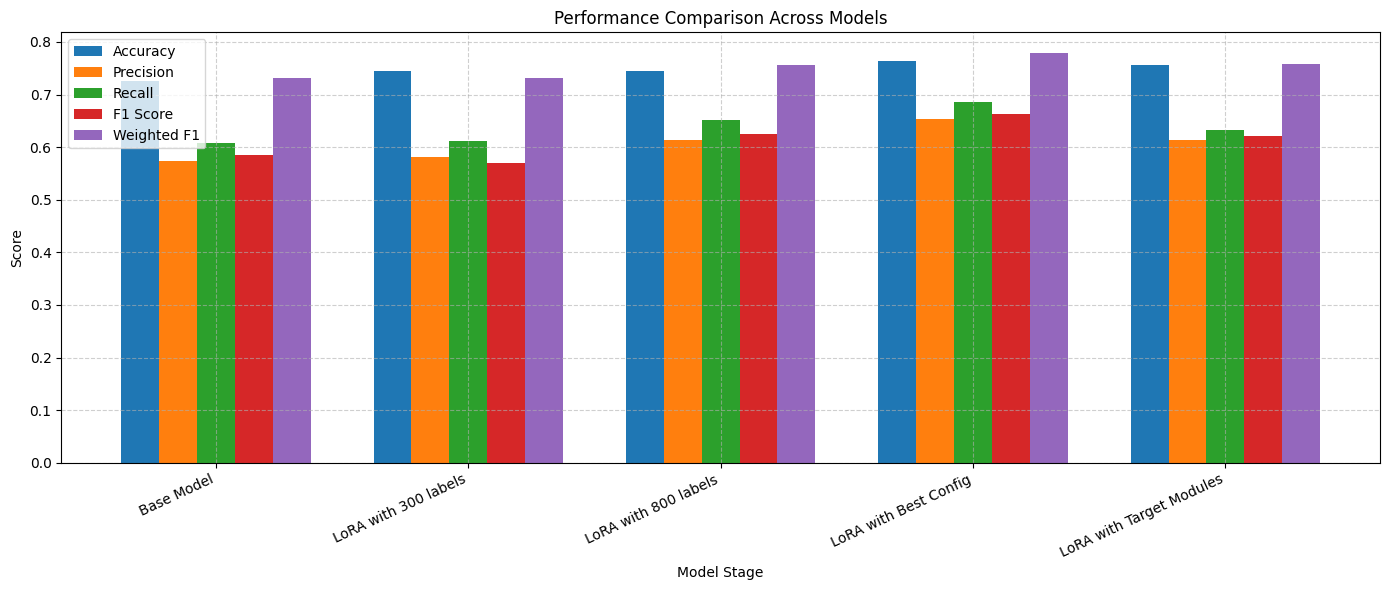

In [ ]:
import numpy as np

# Set figure size
plt.figure(figsize=(14, 6))

# Bar width
bar_width = 0.15

# Set positions for each group
r1 = np.arange(len(lora_eval_df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

# Plotting
plt.bar(r1, lora_eval_df['accuracy'], width=bar_width, label='Accuracy')
plt.bar(r2, lora_eval_df['precision'], width=bar_width, label='Precision')
plt.bar(r3, lora_eval_df['recall'], width=bar_width, label='Recall')
plt.bar(r4, lora_eval_df['f1_score'], width=bar_width, label='F1 Score')
plt.bar(r5, lora_eval_df['weighted_f1'], width=bar_width, label='Weighted F1')

# Label settings
plt.xlabel('Model Stage')
plt.ylabel('Score')
plt.title('Performance Comparison Across Models')
plt.xticks([r + 2*bar_width for r in range(len(lora_eval_df))], lora_eval_df['Stage'], rotation=25, ha='right')

# Grid, legend
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# **Simple UI Creation**

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.0 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load best fine-tuned model
model = T5ForConditionalGeneration.from_pretrained("/content/drive/MyDrive/Team Project A/FlanT5_LoRA_Final")
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Prediction function
def predict_sentiment(text):
    input_text = f"Classify the sentiment of this review as positive, neutral, or negative:\n{text}"
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)
    outputs = model.generate(**inputs)
    pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return pred.strip()

# Build Gradio Interface
iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=5, placeholder="Enter a drug review here..."),
    outputs="text",
    title="Drug Review Sentiment Classifier",
    description="Enter a drug review. The model will classify it as Positive, Neutral, or Negative."
)

# Launch
iface.launch()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://18951e8edda8c54c2c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
